## Setup


In [1]:
import numpy as np
from type_definitions.utils import *
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn.neural_network import MLPRegressor

# Suppress sklearn overflow warnings (common after migration due to numpy/sklearn version changes)
import warnings

warnings.filterwarnings(
    "ignore", category=RuntimeWarning, message="overflow encountered in matmul"
)
warnings.filterwarnings("ignore", category=RuntimeWarning, module="sklearn")

# Set numpy error handling to prevent numerical instability issues
np.seterr(over="ignore", invalid="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Simulation


In [2]:
seed = 100

np.random.seed(seed)

# Generate cases with constraint on velocity angle difference
# Constrain to cases where angle between ownship and intruder velocities is within range
# This reduces the number of cases and makes distance matrix calculation faster
# Range: π/6 to π/2 (30 to 90 degrees) - focuses on convergent/conflict scenarios
velocity_angle_diff_range = (np.pi / 6, np.pi / 3)

# Generate fewer cases since we're filtering
cases = generate_acasxu_dubins_cases(
    800,
    intruder_can_turn=True,
    velocity_angle_diff_range=velocity_angle_diff_range,  # Reduced from 100000
)
results = evaluate_acasxu_dubins_cases(cases)
# Extract ownship trajectories (aircraft 0) from valid results
trajectories = [
    extract_acasxu_dubins_trajectory(r, aircraft_index=0)
    for r in results
    if not r.simulation_failed
]
valid_results = [r for r in results if not r.simulation_failed]
print(
    f"Generated {len(trajectories)} trajectories ({sum(1 for r in valid_results if r.collision_occurred)} collisions)"
)

Generated 800 trajectories (0 collisions)


In [3]:
# Analyze scenarios
collision_results = [r for r in valid_results if r.collision_occurred]
safe_results = [r for r in valid_results if not r.collision_occurred]
violated_results = [r for r in valid_results if r.violated_safety_limits]
print(
    f"Collision: {len(collision_results)}, Safe: {len(safe_results)}, Violations: {len(violated_results)}"
)

Collision: 0, Safe: 800, Violations: 0


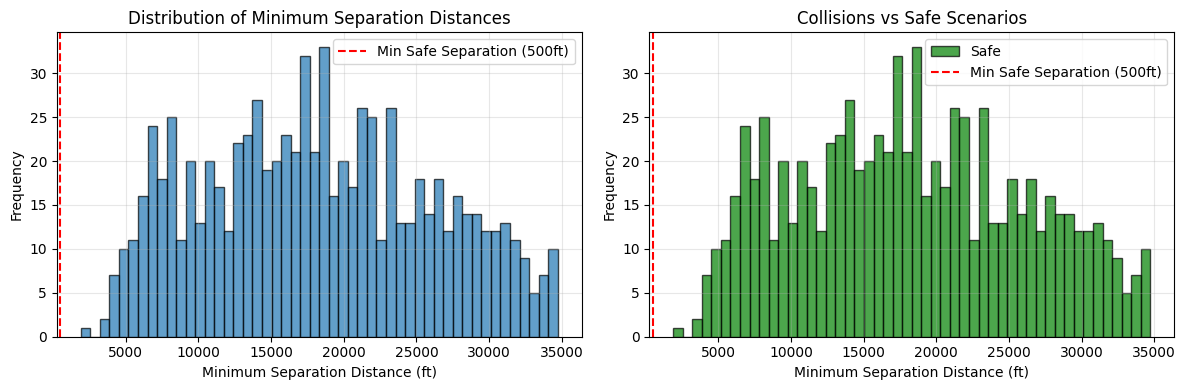

In [4]:
# Plot separation distance histogram
separations = [r.min_separation for r in valid_results]
collision_separations = (
    [r.min_separation for r in collision_results] if len(collision_results) > 0 else []
)
safe_separations = [r.min_separation for r in safe_results]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Histogram of all separations
ax1.hist(separations, bins=50, alpha=0.7, edgecolor="black")
ax1.axvline(500, color="r", linestyle="--", label="Min Safe Separation (500ft)")
ax1.set_xlabel("Minimum Separation Distance (ft)")
ax1.set_ylabel("Frequency")
ax1.set_title("Distribution of Minimum Separation Distances")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Separate histograms for collisions vs safe
if len(collision_separations) > 0:
    ax2.hist(
        collision_separations,
        bins=20,
        alpha=0.7,
        label="Collisions",
        color="red",
        edgecolor="black",
    )
if len(safe_separations) > 0:
    ax2.hist(
        safe_separations,
        bins=50,
        alpha=0.7,
        label="Safe",
        color="green",
        edgecolor="black",
    )
ax2.axvline(500, color="r", linestyle="--", label="Min Safe Separation (500ft)")
ax2.set_xlabel("Minimum Separation Distance (ft)")
ax2.set_ylabel("Frequency")
ax2.set_title("Collisions vs Safe Scenarios")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

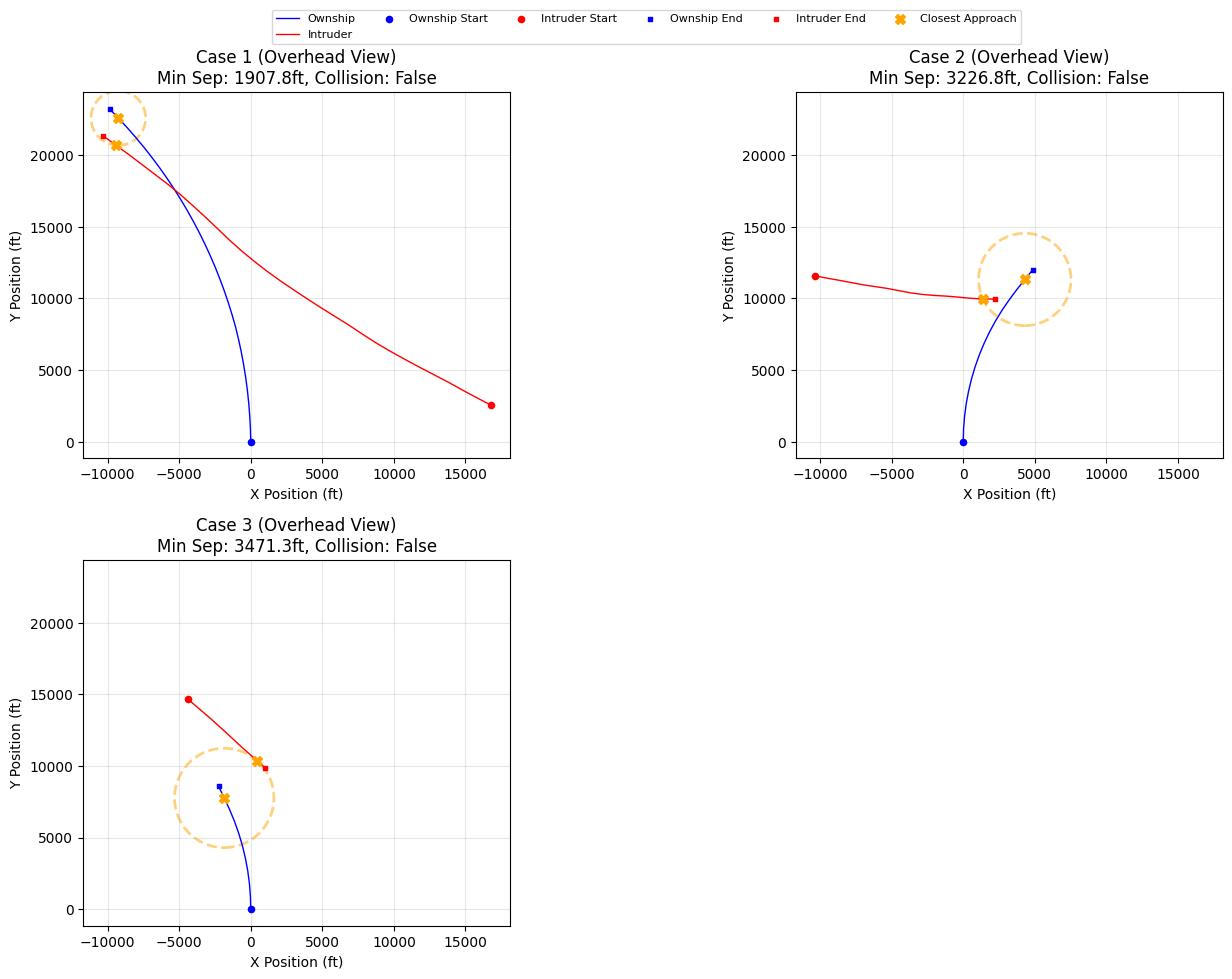

In [5]:
# Plot 2D overhead view of trajectories with minimum min-distances
fig = plt.figure(figsize=(15, 10))
num_examples = 3
ncols = 2
nrows = (num_examples + ncols - 1) // ncols  # Calculate number of rows needed

# Sort by min_separation and take the three with smallest min-distances
sorted_results = sorted(valid_results, key=lambda r: r.min_separation)[:num_examples]

# First pass: collect all x and y ranges to determine common limits
all_x_min, all_x_max = [], []
all_y_min, all_y_max = [], []

for idx in range(num_examples):
    result = sorted_results[idx]
    if len(result.aircraft_trajectories) >= 2:
        ownship_traj = result.aircraft_trajectories[0]
        intruder_traj = result.aircraft_trajectories[1]

        all_x_min.extend([ownship_traj[:, 0].min(), intruder_traj[:, 0].min()])
        all_x_max.extend([ownship_traj[:, 0].max(), intruder_traj[:, 0].max()])
        all_y_min.extend([ownship_traj[:, 1].min(), intruder_traj[:, 1].min()])
        all_y_max.extend([ownship_traj[:, 1].max(), intruder_traj[:, 1].max()])

# Calculate common limits with some padding
x_min, x_max = min(all_x_min), max(all_x_max)
y_min, y_max = min(all_y_min), max(all_y_max)
x_range = x_max - x_min
y_range = y_max - y_min
padding = 0.05  # 5% padding

# Initialize handles and labels for legend
handles = []
labels = []

for idx in range(num_examples):
    result = sorted_results[idx]
    if len(result.aircraft_trajectories) >= 2:
        ax = fig.add_subplot(nrows, ncols, idx + 1)

        ownship_traj = result.aircraft_trajectories[0]
        intruder_traj = result.aircraft_trajectories[1]

        # Plot 2D trajectories (x vs y)
        ax.plot(
            ownship_traj[:, 0],
            ownship_traj[:, 1],
            "b",
            label="Ownship",
            linewidth=1,
            # marker="o",
            markersize=3,
        )
        ax.plot(
            intruder_traj[:, 0],
            intruder_traj[:, 1],
            "r",
            label="Intruder",
            linewidth=1,
            # marker="s",
            markersize=3,
        )

        # Mark start points
        ax.scatter(
            ownship_traj[0, 0],
            ownship_traj[0, 1],
            c="blue",
            marker="o",
            s=20,
            label="Ownship Start",
            zorder=5,
        )
        ax.scatter(
            intruder_traj[0, 0],
            intruder_traj[0, 1],
            c="red",
            marker="o",
            s=20,
            label="Intruder Start",
            zorder=5,
        )

        # Mark end points
        ax.scatter(
            ownship_traj[-1, 0],
            ownship_traj[-1, 1],
            c="blue",
            marker="s",
            s=10,
            label="Ownship End",
            zorder=5,
        )
        ax.scatter(
            intruder_traj[-1, 0],
            intruder_traj[-1, 1],
            c="red",
            marker="s",
            s=10,
            label="Intruder End",
            zorder=5,
        )

        # Find and mark closest approach
        ownship_pos = ownship_traj[:, :2]
        intruder_pos = intruder_traj[:, :2]
        distances = np.sqrt(np.sum((ownship_pos - intruder_pos) ** 2, axis=1))
        min_idx = np.argmin(distances)
        ax.scatter(
            ownship_pos[min_idx, 0],
            ownship_pos[min_idx, 1],
            c="orange",
            marker="X",
            s=50,
            label="Closest Approach",
            zorder=6,
        )
        ax.scatter(
            intruder_pos[min_idx, 0],
            intruder_pos[min_idx, 1],
            c="orange",
            marker="X",
            s=50,
            zorder=6,
        )

        # Draw circle at minimum separation
        circle = Circle(
            (ownship_pos[min_idx, 0], ownship_pos[min_idx, 1]),
            result.min_separation,
            fill=False,
            color="orange",
            linestyle="--",
            linewidth=2,
            alpha=0.5,
        )
        ax.add_patch(circle)

        ax.set_xlabel("X Position (ft)")
        ax.set_ylabel("Y Position (ft)")
        ax.set_title(
            f"Case {idx+1} (Overhead View)\n"
            f"Min Sep: {result.min_separation:.1f}ft, "
            f"Collision: {result.collision_occurred}"
        )
        ax.grid(True, alpha=0.3)
        ax.set_aspect("equal")

        # Set the same limits for all subplots
        ax.set_xlim(x_min - padding * x_range, x_max + padding * x_range)
        ax.set_ylim(y_min - padding * y_range, y_max + padding * y_range)

        # Collect handles and labels from first subplot for legend
        if idx == 0:
            handles, labels = ax.get_legend_handles_labels()

# Create single legend outside all subplots at the top
fig.legend(
    handles, labels, loc="upper center", bbox_to_anchor=(0.5, 0.98), ncol=6, fontsize=8
)

plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()

In [6]:
# Extract combined trajectories: [x1, y1, theta1, x2, y2, theta2] for each test case
combined_trajectories = []

for result in valid_results:
    if len(result.aircraft_trajectories) >= 2:
        ownship_traj = result.aircraft_trajectories[0]  # (len1, 3) with [x, y, theta]
        intruder_traj = result.aircraft_trajectories[1]  # (len2, 3) with [x, y, theta]

        # Handle different lengths by interpolating to max length
        max_len = max(len(ownship_traj), len(intruder_traj))

        if len(ownship_traj) < max_len:
            # Interpolate ownship trajectory
            t_old = np.linspace(0, 1, len(ownship_traj))
            t_new = np.linspace(0, 1, max_len)
            x1_interp = np.interp(t_new, t_old, ownship_traj[:, 0])
            y1_interp = np.interp(t_new, t_old, ownship_traj[:, 1])
            theta1_unwrapped = np.unwrap(ownship_traj[:, 2])
            theta1_interp = np.interp(t_new, t_old, theta1_unwrapped)
            ownship_traj = np.column_stack([x1_interp, y1_interp, theta1_interp])

        if len(intruder_traj) < max_len:
            # Interpolate intruder trajectory
            t_old = np.linspace(0, 1, len(intruder_traj))
            t_new = np.linspace(0, 1, max_len)
            x2_interp = np.interp(t_new, t_old, intruder_traj[:, 0])
            y2_interp = np.interp(t_new, t_old, intruder_traj[:, 1])
            theta2_unwrapped = np.unwrap(intruder_traj[:, 2])
            theta2_interp = np.interp(t_new, t_old, theta2_unwrapped)
            intruder_traj = np.column_stack([x2_interp, y2_interp, theta2_interp])

        # Stack horizontally: [x1, y1, theta1, x2, y2, theta2]
        combined = np.column_stack([ownship_traj, intruder_traj])
        combined_trajectories.append(combined)

print(
    f"Extracted {len(combined_trajectories)} combined trajectories (shape: {combined_trajectories[0].shape})"
)

Extracted 800 combined trajectories (shape: (114, 6))


In [7]:
# Calculate pairwise Dubins Frechet distance matrix
import os

# Create cache directory if it doesn't exist
os.makedirs("cache", exist_ok=True)

distance_matrix_file = (
    f"cache/dubins_distance_matrix_seed{seed}_size{len(combined_trajectories)}.npy"
)

if os.path.exists(distance_matrix_file):
    distance_matrix = np.load(distance_matrix_file)
else:
    distance_matrix = pairwise_dubins_distances(
        combined_trajectories, distance_type="dtw"
    )
    np.save(distance_matrix_file, distance_matrix)

print(f"Distance matrix: {distance_matrix.shape}")

# Calculate coverage metrics
fixed_bins = 40
iu0 = np.triu_indices(distance_matrix.shape[0], k=1)
d0 = distance_matrix[iu0]
fixed_range = (float(d0.min()), float(d0.max()))
width, uniformity = frechet_coverage(
    distance_matrix, bins=fixed_bins, hist_range=fixed_range
)

Distance matrix: (800, 800)


In [8]:
# Hybrid approach: Extract both initial conditions AND trajectory features
# We'll train a model to predict trajectory features from initial conditions


def extract_initial_conditions(test_case) -> np.ndarray:
    """Extract only initial conditions (6 features)"""
    return np.array(
        [
            test_case.separation,
            test_case.ownship_v,
            test_case.intruder_v,
            test_case.ownship_theta,
            test_case.intruder_placement_angle,
            test_case.intruder_theta,
        ]
    )


def extract_trajectory_features(trajectory_idx: int, trajectories) -> np.ndarray:
    """Extract trajectory-derived features (7 features)"""
    traj = trajectories[trajectory_idx]

    # Trajectory length
    traj_length = len(traj)

    # Path lengths
    ownship_path_length = np.sum(
        np.sqrt(np.diff(traj[:, 0]) ** 2 + np.diff(traj[:, 1]) ** 2)
    )
    intruder_path_length = np.sum(
        np.sqrt(np.diff(traj[:, 3]) ** 2 + np.diff(traj[:, 4]) ** 2)
    )

    # Separation statistics
    separations = np.sqrt(
        (traj[:, 0] - traj[:, 3]) ** 2 + (traj[:, 1] - traj[:, 4]) ** 2
    )
    avg_separation = np.mean(separations)
    min_separation = np.min(separations)

    # Heading variability
    ownship_heading_var = np.sum(np.abs(np.diff(np.unwrap(traj[:, 2]))))
    intruder_heading_var = np.sum(np.abs(np.diff(np.unwrap(traj[:, 5]))))

    return np.array(
        [
            traj_length,
            ownship_path_length,
            intruder_path_length,
            avg_separation,
            min_separation,
            ownship_heading_var,
            intruder_heading_var,
        ]
    )


# Extract both types of features
test_cases = [r.test_case for r in valid_results]
initial_conditions = np.array([extract_initial_conditions(case) for case in test_cases])
trajectory_features = np.array(
    [
        extract_trajectory_features(idx, combined_trajectories)
        for idx in range(len(test_cases))
    ]
)

print(
    f"Initial conditions: {initial_conditions.shape}, Trajectory features: {trajectory_features.shape}"
)

Initial conditions: (800, 6), Trajectory features: (800, 7)


In [9]:
# Train MLP-based trajectory feature predictor
# MLPs can better capture complex, non-linear decision boundaries

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

print("Training Trajectory Feature Predictor (MLP)...")

# Normalize initial conditions for MLP training
from sklearn.preprocessing import StandardScaler

ic_scaler = StandardScaler()
initial_conditions_scaled = ic_scaler.fit_transform(initial_conditions)

# Split data for proper evaluation
ic_train, ic_test, tf_train, tf_test = train_test_split(
    initial_conditions_scaled, trajectory_features, test_size=0.2, random_state=seed
)

# Train separate MLP models for each trajectory feature
trajectory_predictors = []
traj_feature_names = [
    "traj_length",
    "ownship_path",
    "intruder_path",
    "avg_sep",
    "min_sep",
    "own_heading_var",
    "int_heading_var",
]

print("Training R² (train) | Test R² (unseen data):")
print("-" * 50)

for i, name in enumerate(traj_feature_names):
    # MLP with multiple hidden layers
    mlp_traj = MLPRegressor(
        hidden_layer_sizes=(128, 64, 32),
        activation="relu",
        solver="adam",
        learning_rate="adaptive",
        max_iter=1000,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=20,
        random_state=seed,
        verbose=False,
    )

    # Scale target for better training
    target_mean = tf_train[:, i].mean()
    target_std = tf_train[:, i].std()
    target_train_scaled = (tf_train[:, i] - target_mean) / (target_std + 1e-8)

    mlp_traj.fit(ic_train, target_train_scaled)

    # Store model with scaling info
    mlp_traj._target_mean = target_mean
    mlp_traj._target_std = target_std

    # Training R² (on training data)
    pred_train = mlp_traj.predict(ic_train) * target_std + target_mean
    r2_train = 1 - np.sum((tf_train[:, i] - pred_train) ** 2) / np.sum(
        (tf_train[:, i] - np.mean(tf_train[:, i])) ** 2
    )

    # Test R² (on unseen data)
    pred_test = mlp_traj.predict(ic_test) * target_std + target_mean
    r2_test = 1 - np.sum((tf_test[:, i] - pred_test) ** 2) / np.sum(
        (tf_test[:, i] - np.mean(tf_test[:, i])) ** 2
    )

    print(f"  {name:<18}: Train R² = {r2_train:.4f} | Test R² = {r2_test:.4f}")

    trajectory_predictors.append(mlp_traj)

print(f"\nMLP Trajectory feature predictor trained!")
print(f"\nTrajectory predictor trained!")

Training Trajectory Feature Predictor (MLP)...
Training R² (train) | Test R² (unseen data):
--------------------------------------------------
  traj_length       : Train R² = 0.4145 | Test R² = 0.3010
  ownship_path      : Train R² = 0.6739 | Test R² = 0.3436
  intruder_path     : Train R² = 0.6789 | Test R² = 0.3266
  avg_sep           : Train R² = 0.9673 | Test R² = 0.8967
  min_sep           : Train R² = 0.9318 | Test R² = 0.8264
  own_heading_var   : Train R² = 0.0463 | Test R² = 0.0023
  int_heading_var   : Train R² = 0.4207 | Test R² = 0.3009

MLP Trajectory feature predictor trained!

Trajectory predictor trained!


In [10]:
# Create pairwise features using PREDICTED trajectory features (MLP-based)
# This simulates the inference scenario where we don't have actual trajectories


def predict_trajectory_features_mlp(
    initial_conditions: np.ndarray, trajectory_predictors: list, ic_scaler
) -> np.ndarray:
    """Predict trajectory features using MLP models with proper scaling."""
    ic_scaled = ic_scaler.transform(initial_conditions)
    n = initial_conditions.shape[0]
    predicted_traj = np.zeros((n, 7))
    for i, predictor in enumerate(trajectory_predictors):
        pred_scaled = predictor.predict(ic_scaled)
        predicted_traj[:, i] = (
            pred_scaled * predictor._target_std + predictor._target_mean
        )
    return predicted_traj


def create_pairwise_features_hybrid(
    initial_conditions: np.ndarray,
    trajectory_predictors: list,
    distance_matrix: np.ndarray,
    ic_scaler,
    augment_data: bool = False,  # DISABLED by default - see note below
    n_synthetic: int = 2,  # Reduced from 5 to avoid overwhelming real data
) -> tuple:
    """
    Create pairwise features using predicted trajectory features (MLP-based).

    NOTE on Data Augmentation:
    - In GCAS, augmentation helps because trajectory behavior is more complex
    - In ACASXU, the MLP predictors already create smooth feature mappings
    - Too much augmentation makes the model learn Euclidean distance only,
      which defeats the purpose of using trajectory-based distances
    - Keep augmentation DISABLED unless CMA-ES shows gradient issues
    """
    n = initial_conditions.shape[0]
    pairwise_features = []
    distances = []

    # Predict trajectory features using MLP with proper scaling
    predicted_traj_features = predict_trajectory_features_mlp(
        initial_conditions, trajectory_predictors, ic_scaler
    )

    # Combine initial conditions with predicted trajectory features
    combined_features = np.hstack([initial_conditions, predicted_traj_features])

    # Angular feature indices: [3, 4, 5] in initial conditions
    angular_indices = [3, 4, 5]

    # Track real pairs for augmentation
    real_euclidean = []
    real_dtw = []

    # Create pairwise features (upper triangular only, no diagonal for training)
    for i in range(n):
        for j in range(i + 1, n):  # Exclude diagonal (i=j gives trivial zero pairs)
            # Feature differences
            feat_diff = combined_features[i] - combined_features[j]
            feat_abs_diff = np.abs(feat_diff)

            # Euclidean distance
            euclidean_dist = np.linalg.norm(feat_diff)

            # Angular differences (only for initial conditions)
            angular_diffs = []
            for idx in angular_indices:
                diff = feat_diff[idx]
                while diff > np.pi:
                    diff -= 2 * np.pi
                while diff < -np.pi:
                    diff += 2 * np.pi
                angular_diffs.append(diff)

            # Combine: 13 diff + 13 abs_diff + 1 euclidean + 3 angular = 30 features
            combined = np.concatenate(
                [
                    feat_diff,
                    feat_abs_diff,
                    [euclidean_dist],
                    angular_diffs,
                ]
            )

            pairwise_features.append(combined)
            distances.append(distance_matrix[i, j])

            # Track for augmentation
            real_euclidean.append(euclidean_dist)
            real_dtw.append(distance_matrix[i, j])

    n_real_pairs = len(distances)
    print(f"  Real pairwise samples: {n_real_pairs}")

    # ==================================================================
    # OPTIONAL: Data Augmentation (disabled by default for ACASXU)
    # Only enable if optimization shows gradient discontinuity issues
    # ==================================================================
    if augment_data and len(real_euclidean) > 0:
        print("  Adding synthetic near-neighbor pairs for gradient smoothing...")

        # Calculate average ratio between DTW and Euclidean distance
        ratios = np.array(real_dtw) / (np.array(real_euclidean) + 1e-8)
        avg_ratio = np.median(ratios)
        print(f"  Median DTW/Euclidean ratio: {avg_ratio:.4f}")

        # Feature standard deviations for noise scaling
        feature_std = np.std(combined_features, axis=0)
        feature_std[feature_std == 0] = 1.0

        n_augmented = 0
        for i in range(n):
            for _ in range(n_synthetic):
                # Generate small random noise (0.5% to 2% of feature std - very small!)
                noise_scale = np.random.uniform(0.005, 0.02)
                noise = np.random.normal(0, feature_std * noise_scale)

                feat_neighbor = combined_features[i] + noise

                feat_diff = combined_features[i] - feat_neighbor
                feat_abs_diff = np.abs(feat_diff)
                euclidean_dist = np.linalg.norm(feat_diff)

                angular_diffs = []
                for idx in angular_indices:
                    diff = feat_diff[idx]
                    while diff > np.pi:
                        diff -= 2 * np.pi
                    while diff < -np.pi:
                        diff += 2 * np.pi
                    angular_diffs.append(diff)

                combined = np.concatenate(
                    [feat_diff, feat_abs_diff, [euclidean_dist], angular_diffs]
                )

                estimated_dist = avg_ratio * euclidean_dist

                pairwise_features.append(combined)
                distances.append(estimated_dist)
                n_augmented += 1

        print(f"  Added {n_augmented} synthetic pairs")
        print(f"  Augmentation ratio: {n_augmented / n_real_pairs:.2%} of real data")

    print(f"  Total training samples: {len(distances)}")
    return np.array(pairwise_features), np.array(distances)


X, y = create_pairwise_features_hybrid(
    initial_conditions,
    trajectory_predictors,
    distance_matrix,
    ic_scaler,
    augment_data=False,
    n_synthetic=2,
)

print(f"Pairwise features: {X.shape}, Distances: {y.shape}")

  Real pairwise samples: 319600
  Total training samples: 319600
Pairwise features: (319600, 30), Distances: (319600,)


## Coverage Distance

Generate test cases using coverage-guided methods, comparing:

1. **Greedy with Predictor**: Uses encoder + BallTree for novelty search with predicted distances
2. **CMA-ES RF**: Uses CMA-ES optimization with RF predictor
3. **Random**: Random baseline


In [11]:
# Coverage Distance Helper Functions (Optimized for MLP predictors)

from sklearn.neighbors import BallTree
import cma
from scipy import stats
import seaborn as sns
import time
import os


def get_combined_features_hybrid(
    initial_conds: np.ndarray,
    trajectory_predictors: list,
    ic_scaler,
) -> np.ndarray:
    """
    Get combined features (initial + predicted trajectory) for given initial conditions.
    Uses MLP predictors with proper scaling.
    """
    if len(initial_conds.shape) == 1:
        initial_conds = initial_conds.reshape(1, -1)

    # Predict trajectory features using MLP with proper scaling
    predicted_traj = predict_trajectory_features_mlp(
        initial_conds, trajectory_predictors, ic_scaler
    )

    return np.hstack([initial_conds, predicted_traj])


def create_pairwise_features_batch(
    candidate_features: np.ndarray,  # (1, 13)
    existing_features: np.ndarray,  # (n, 13)
) -> np.ndarray:
    """
    Create pairwise features between one candidate and multiple existing test cases.
    Fully vectorized for speed.

    Returns: (n, 30) array of pairwise features
    """
    n = existing_features.shape[0]

    # Broadcast candidate to match existing
    candidate_broadcast = np.tile(candidate_features, (n, 1))  # (n, 13)

    # Feature differences
    feat_diff = candidate_broadcast - existing_features  # (n, 13)
    feat_abs_diff = np.abs(feat_diff)  # (n, 13)

    # Euclidean distance
    euclidean_dist = np.linalg.norm(feat_diff, axis=1, keepdims=True)  # (n, 1)

    # Angular differences for indices 3, 4, 5
    angular_diffs = feat_diff[:, [3, 4, 5]].copy()  # (n, 3)
    angular_diffs = (
        np.mod(angular_diffs + np.pi, 2 * np.pi) - np.pi
    )  # wrap to [-pi, pi]

    # Combine: 13 diff + 13 abs_diff + 1 euclidean + 3 angular = 30
    return np.hstack([feat_diff, feat_abs_diff, euclidean_dist, angular_diffs])


def novelty_score_batch(
    candidate_initial: np.ndarray,
    existing_initials: np.ndarray,
    trajectory_predictors: list,
    rf_model,
    scaler,
    ic_scaler,
    existing_features: np.ndarray = None,  # Pre-computed for speed
) -> float:
    """
    Calculate novelty score using vectorized operations.
    Returns minimum predicted distance to existing test cases.
    Uses MLP predictors with proper scaling.
    """
    if len(existing_initials) == 0:
        return float("inf")

    # Get candidate features using MLP predictors
    candidate_features = get_combined_features_hybrid(
        candidate_initial.reshape(1, -1), trajectory_predictors, ic_scaler
    )  # (1, 13)

    # Use pre-computed features if available, otherwise compute
    if existing_features is None:
        existing_features = get_combined_features_hybrid(
            existing_initials, trajectory_predictors, ic_scaler
        )

    # Create all pairwise features at once
    pairwise_feats = create_pairwise_features_batch(
        candidate_features, existing_features
    )  # (n, 30)

    # Scale and predict all at once
    pairwise_feats_scaled = scaler.transform(pairwise_feats)
    distances = rf_model.predict(pairwise_feats_scaled)

    return np.min(distances)


print("Coverage helper functions defined")

Coverage helper functions defined


In [12]:
# Coverage Generation Methods (Optimized for MLP predictors)

# Fixed ownship parameters: position at origin, facing north, fixed velocity
FIXED_OWNSHIP_V = 800.0  # ft/s
FIXED_OWNSHIP_THETA = np.pi / 2  # facing north

# Parameter bounds for AcasXuDubinsTestCase
# Ownship is FIXED - only intruder parameters vary
PARAM_BOUNDS = {
    "separation": (10000.0, 40000.0),
    "ownship_v": (FIXED_OWNSHIP_V, FIXED_OWNSHIP_V),  # fixed
    "intruder_v": (0.0, 1200.0),
    "ownship_theta": (FIXED_OWNSHIP_THETA, FIXED_OWNSHIP_THETA),  # fixed
    "intruder_placement_angle": (0.0, 2 * np.pi),
    "intruder_theta": (0.0, 2 * np.pi),
}

BOUNDS_LOWER = np.array([v[0] for v in PARAM_BOUNDS.values()])
BOUNDS_UPPER = np.array([v[1] for v in PARAM_BOUNDS.values()])

# Velocity angle constraint (relative to fixed ownship heading)
VELOCITY_ANGLE_CONSTRAINT = (np.pi / 6, np.pi / 3)


def compute_velocity_angle_diff(x: np.ndarray) -> float:
    """Compute velocity angle difference for a single point or batch."""
    if len(x.shape) == 1:
        ownship_theta = x[3]
        intruder_theta = x[5]
    else:
        ownship_theta = x[:, 3]
        intruder_theta = x[:, 5]
    diff = np.abs(ownship_theta - intruder_theta)
    diff = np.minimum(diff, 2 * np.pi - diff)
    return diff


def satisfies_velocity_constraint(x: np.ndarray) -> bool:
    """Check if point(s) satisfy the velocity angle constraint."""
    diff = compute_velocity_angle_diff(x)
    return np.all(
        (diff >= VELOCITY_ANGLE_CONSTRAINT[0]) & (diff <= VELOCITY_ANGLE_CONSTRAINT[1])
    )


def sample_random_initial_conditions_constrained(
    n_samples: int,
    seed: int = None,
) -> np.ndarray:
    """Sample random initial conditions with fixed ownship and velocity angle constraint.

    Ownship is fixed: origin, facing north (θ=π/2), v=FIXED_OWNSHIP_V.
    Only intruder parameters vary.
    """
    if seed is not None:
        np.random.seed(seed)

    samples = []
    for _ in range(n_samples):
        separation = np.random.uniform(
            PARAM_BOUNDS["separation"][0], PARAM_BOUNDS["separation"][1]
        )
        intruder_v = np.random.uniform(
            PARAM_BOUNDS["intruder_v"][0], PARAM_BOUNDS["intruder_v"][1]
        )
        intruder_placement_angle = np.random.uniform(0, 2 * np.pi)
        # Intruder heading: constrained angle diff from fixed ownship heading
        angle_diff = np.random.uniform(
            VELOCITY_ANGLE_CONSTRAINT[0], VELOCITY_ANGLE_CONSTRAINT[1]
        )
        direction = np.random.choice([-1, 1])
        intruder_theta = (FIXED_OWNSHIP_THETA + direction * angle_diff) % (2 * np.pi)

        sample = np.array(
            [
                separation,
                FIXED_OWNSHIP_V,  # fixed
                intruder_v,
                FIXED_OWNSHIP_THETA,  # fixed (north)
                intruder_placement_angle,
                intruder_theta,
            ]
        )
        samples.append(sample)

    return np.array(samples)


def sample_random_initial_conditions(n_samples: int, seed: int = None) -> np.ndarray:
    """Sample random initial conditions with fixed ownship (unconstrained angle)."""
    if seed is not None:
        np.random.seed(seed)
    samples = np.random.uniform(BOUNDS_LOWER, BOUNDS_UPPER, (n_samples, 6))
    # Ensure ownship params are fixed (in case bounds have zero-width range)
    samples[:, 1] = FIXED_OWNSHIP_V
    samples[:, 3] = FIXED_OWNSHIP_THETA
    return samples


def coverage_distance_with_cma_es_fast(
    init_initial_conditions: np.ndarray,
    trajectory_predictors: list,
    model,
    scaler,
    ic_scaler,
    n_cycles: int = 10,
    cma_popsize: int = 20,
    cma_maxiter: int = 30,
    verbose: bool = True,
    constrained: bool = True,
    constraint_penalty: float = 1e10,
) -> tuple:
    """CMA-ES coverage generation with MLP surrogate."""
    current_initials = init_initial_conditions.copy()
    current_features = get_combined_features_hybrid(
        current_initials, trajectory_predictors, ic_scaler
    )
    new_initials = []
    generation_times = []

    for cycle in range(n_cycles):
        start_time = time.time()

        def objective(x):
            x_clipped = np.clip(x, BOUNDS_LOWER, BOUNDS_UPPER)
            novelty = -novelty_score_batch(
                x_clipped,
                current_initials,
                trajectory_predictors,
                model,
                scaler,
                ic_scaler,
                existing_features=current_features,
            )
            if constrained:
                angle_diff = compute_velocity_angle_diff(x_clipped)
                if (
                    angle_diff < VELOCITY_ANGLE_CONSTRAINT[0]
                    or angle_diff > VELOCITY_ANGLE_CONSTRAINT[1]
                ):
                    violation = min(
                        abs(angle_diff - VELOCITY_ANGLE_CONSTRAINT[0]),
                        abs(angle_diff - VELOCITY_ANGLE_CONSTRAINT[1]),
                    )
                    novelty += constraint_penalty * violation**2
            return novelty

        if constrained:
            x0 = sample_random_initial_conditions_constrained(1)[0]
        else:
            x0 = sample_random_initial_conditions(1)[0]
        sigma0 = 0.3 * (BOUNDS_UPPER - BOUNDS_LOWER).mean()

        es = cma.CMAEvolutionStrategy(
            x0,
            sigma0,
            {
                "popsize": cma_popsize,
                "bounds": [BOUNDS_LOWER.tolist(), BOUNDS_UPPER.tolist()],
                "verbose": -9,
                "maxiter": cma_maxiter,
            },
        )
        es.optimize(objective)
        best_solution = np.clip(es.result.xbest, BOUNDS_LOWER, BOUNDS_UPPER)

        elapsed_time = time.time() - start_time
        generation_times.append(elapsed_time)

        new_initials.append(best_solution)
        current_initials = np.vstack([current_initials, best_solution])
        new_features = get_combined_features_hybrid(
            best_solution.reshape(1, -1), trajectory_predictors, ic_scaler
        )
        current_features = np.vstack([current_features, new_features])

        if verbose and (cycle + 1) % 5 == 0:
            print(f"  Cycle {cycle + 1}/{n_cycles}: time = {elapsed_time:.2f}s")

    return np.array(new_initials), np.array(generation_times)


def coverage_distance_random(
    init_initial_conditions: np.ndarray,
    n_cycles: int = 10,
    seed: int | None = None,
    constrained: bool = True,
) -> tuple:
    """Generate random test cases (baseline)."""
    start_time = time.time()
    if constrained:
        new_initials = sample_random_initial_conditions_constrained(n_cycles, seed)
    else:
        new_initials = sample_random_initial_conditions(n_cycles, seed)
    total_time = time.time() - start_time
    return new_initials, np.full(n_cycles, total_time / n_cycles)


def coverage_distance_greedy(
    init_initial_conditions: np.ndarray,
    pool_initial_conditions: np.ndarray,
    trajectory_predictors: list,
    model,
    scaler,
    ic_scaler,
    n_cycles: int = 10,
    verbose: bool = True,
) -> tuple:
    """Greedy selection from pool using MLP surrogate."""
    current_initials = init_initial_conditions.copy()
    current_features = get_combined_features_hybrid(
        current_initials, trajectory_predictors, ic_scaler
    )
    available_indices = list(range(len(pool_initial_conditions)))
    selected_initials = []
    generation_times = []
    pool_features = get_combined_features_hybrid(
        pool_initial_conditions, trajectory_predictors, ic_scaler
    )

    for cycle in range(n_cycles):
        if not available_indices:
            break
        start_time = time.time()
        best_idx = None
        best_novelty = -np.inf

        for pool_idx in available_indices:
            candidate_features = pool_features[pool_idx : pool_idx + 1]
            pairwise_feats = create_pairwise_features_batch(
                candidate_features, current_features
            )
            pairwise_feats_scaled = scaler.transform(pairwise_feats)
            distances = model.predict(pairwise_feats_scaled)
            min_dist = np.min(distances)

            if min_dist > best_novelty:
                best_novelty = min_dist
                best_idx = pool_idx

        best_solution = pool_initial_conditions[best_idx]
        available_indices.remove(best_idx)

        elapsed_time = time.time() - start_time
        generation_times.append(elapsed_time)

        selected_initials.append(best_solution)
        current_initials = np.vstack([current_initials, best_solution])
        new_features = pool_features[best_idx : best_idx + 1]
        current_features = np.vstack([current_features, new_features])

        if verbose and (cycle + 1) % 5 == 0:
            print(
                f"  Cycle {cycle + 1}/{n_cycles}: time = {elapsed_time:.2f}s, novelty = {best_novelty:.0f}"
            )

    return np.array(selected_initials), np.array(generation_times)


def coverage_distance_greedy_maxmin_generated(
    init_initial_conditions: np.ndarray,
    n_cycles: int = 10,
    n_candidates: int = 50,
    intruder_cmd_seed: int = 42,
    verbose: bool = True,
    constrained: bool = True,
) -> tuple:
    """
    Greedy max-min that GENERATES candidates (not pooled) and uses ACTUAL DTW distances.

    For each cycle:
    1. Generate n_candidates random initial conditions
    2. Simulate all candidates to get trajectories
    3. Compute actual DTW distances to selected set
    4. Select the candidate with maximum minimum distance
    """
    from fastdtw import fastdtw
    from scipy.spatial.distance import euclidean

    current_initials = init_initial_conditions.copy()
    new_initials = []
    generation_times = []

    # Simulate initial conditions to get their trajectories
    init_cases = initial_conditions_to_testcases(
        current_initials, intruder_can_turn=True, seed=intruder_cmd_seed
    )
    init_results = evaluate_acasxu_dubins_cases(init_cases)
    current_trajectories = [
        extract_acasxu_dubins_trajectory(r, aircraft_index=-1)
        for r in init_results
        if not r.simulation_failed
    ]

    for cycle in range(n_cycles):
        start_time = time.time()

        # Generate random candidates
        if constrained:
            candidates = sample_random_initial_conditions_constrained(n_candidates)
        else:
            candidates = sample_random_initial_conditions(n_candidates)

        # Simulate all candidates
        candidate_cases = initial_conditions_to_testcases(
            candidates, intruder_can_turn=True, seed=intruder_cmd_seed + cycle
        )
        candidate_results = evaluate_acasxu_dubins_cases(candidate_cases)

        # Extract trajectories for valid candidates
        candidate_trajectories = []
        valid_candidate_indices = []
        for i, r in enumerate(candidate_results):
            if not r.simulation_failed:
                traj = extract_acasxu_dubins_trajectory(r, aircraft_index=-1)
                candidate_trajectories.append(traj)
                valid_candidate_indices.append(i)

        if len(candidate_trajectories) == 0:
            if verbose:
                print(f"  Cycle {cycle + 1}: No valid candidates, skipping")
            continue

        # Find candidate with max min distance to current set
        best_idx = None
        best_min_dist = -np.inf
        best_traj = None

        for i, cand_traj in enumerate(candidate_trajectories):
            min_dist = np.inf
            for curr_traj in current_trajectories:
                dist, _ = fastdtw(cand_traj, curr_traj, dist=euclidean)
                if dist < min_dist:
                    min_dist = dist

            if min_dist > best_min_dist:
                best_min_dist = min_dist
                best_idx = valid_candidate_indices[i]
                best_traj = cand_traj

        # Select the best candidate
        best_solution = candidates[best_idx]
        new_initials.append(best_solution)
        current_initials = np.vstack([current_initials, best_solution])
        current_trajectories.append(best_traj)

        elapsed_time = time.time() - start_time
        generation_times.append(elapsed_time)

        if verbose and (cycle + 1) % 5 == 0:
            in_constraint = satisfies_velocity_constraint(best_solution)
            print(
                f"  Cycle {cycle + 1}/{n_cycles}: time = {elapsed_time:.2f}s, min_dist = {best_min_dist:.0f}, in_constraint={in_constraint}"
            )

    return np.array(new_initials), np.array(generation_times)


print(
    f"Coverage methods defined (constraint: [{VELOCITY_ANGLE_CONSTRAINT[0]:.4f}, {VELOCITY_ANGLE_CONSTRAINT[1]:.4f}])"
)

Coverage methods defined (constraint: [0.5236, 1.0472])


In [13]:
# ============================================================
# ACTUAL TRAJECTORY EVALUATION (Ground Truth)
# ============================================================
# Runs real simulations and computes actual DTW distances.
# Provides independent ground truth for fair comparison.


def initial_conditions_to_testcases(
    initial_conditions: np.ndarray,
    intruder_can_turn: bool = True,
    num_inputs: int = 150,
    seed: int = None,
) -> List[AcasXuDubinsTestCase]:
    """
    Convert initial conditions array to AcasXuDubinsTestCase objects.

    Args:
        initial_conditions: (n, 6) array with columns:
            [separation, ownship_v, intruder_v, ownship_theta,
             intruder_placement_angle, intruder_theta]
        intruder_can_turn: Whether intruder can turn (random commands)
        num_inputs: Number of intruder command inputs
        seed: Random seed for reproducible intruder commands.
              If provided, we use (seed + index) for each case.
              This ensures determinism (same run = same results)
              BUT preserves diversity (different cases = different intruder behaviors),
              matching the distribution the surrogate model was trained on.

    Returns:
        List of AcasXuDubinsTestCase objects
    """
    cases = []
    for i, ic in enumerate(initial_conditions):
        (
            separation,
            ownship_v,
            intruder_v,
            ownship_theta,
            intruder_placement_angle,
            intruder_theta,
        ) = ic

        # Generate intruder command list
        if intruder_can_turn:
            if seed is not None:
                np.random.seed(seed + i)
            intruder_cmd_list = [np.random.randint(5) for _ in range(num_inputs)]
        else:
            intruder_cmd_list = [0] * num_inputs

        case = AcasXuDubinsTestCase(
            separation=separation,
            ownship_x=0.0,
            ownship_y=0.0,
            ownship_theta=ownship_theta,
            ownship_v=ownship_v,
            intruder_placement_angle=intruder_placement_angle,
            intruder_theta=intruder_theta,
            intruder_v=intruder_v,
            tau_init=0,  # Standard starting time
            tau_dot=0,
            intruder_cmd_list=intruder_cmd_list,
        )
        cases.append(case)

    return cases


def evaluate_coverage_actual(
    generated_initial_conditions: np.ndarray,
    validation_initial_conditions: np.ndarray,
    intruder_cmd_seed: int = 42,
    verbose: bool = True,
) -> dict:
    """
    Evaluate coverage using ACTUAL DTW distances between trajectories.

    Uses deterministic intruder commands (via seed) to ensure fair comparison.

    Args:
        generated_initial_conditions: (n_gen, 6) initial conditions from generation method
        validation_initial_conditions: (n_val, 6) validation set initial conditions
        intruder_cmd_seed: Seed for reproducible intruder commands
        verbose: Whether to print progress

    Returns:
        Dictionary with coverage metrics based on actual DTW distances
    """
    n_gen = len(generated_initial_conditions)
    n_val = len(validation_initial_conditions)

    if verbose:
        print(f"  Running actual simulations: {n_gen} generated, {n_val} validation...")

    # Convert to test cases with consistent intruder commands
    # Use the SAME base seed for all sets to ensure reproducibility
    # The function will use (seed + i) internally for diversity
    gen_cases = initial_conditions_to_testcases(
        generated_initial_conditions, intruder_can_turn=True, seed=intruder_cmd_seed
    )
    val_cases = initial_conditions_to_testcases(
        validation_initial_conditions,
        intruder_can_turn=True,
        seed=intruder_cmd_seed,  # Use SAME seed for validation to match scenario
    )

    # Run simulations
    if verbose:
        print(f"  Simulating generated cases...")
    gen_results = evaluate_acasxu_dubins_cases(gen_cases)

    if verbose:
        print(f"  Simulating validation cases...")
    val_results = evaluate_acasxu_dubins_cases(val_cases)

    # Extract trajectories (combined ownship + intruder)
    gen_trajectories = [
        extract_acasxu_dubins_trajectory(r, aircraft_index=-1)  # Combined
        for r in gen_results
        if not r.simulation_failed
    ]
    val_trajectories = [
        extract_acasxu_dubins_trajectory(r, aircraft_index=-1)
        for r in val_results
        if not r.simulation_failed
    ]

    if len(gen_trajectories) == 0 or len(val_trajectories) == 0:
        return {
            "mean_min_dist": np.inf,
            "median_min_dist": np.inf,
            "max_min_dist": np.inf,
            "min_distances": np.array([]),
            "coverage_score": np.inf,
            "n_valid_gen": len(gen_trajectories),
            "n_valid_val": len(val_trajectories),
        }

    if verbose:
        print(
            f"  Computing DTW distances ({len(gen_trajectories)} x {len(val_trajectories)})..."
        )

    # Compute pairwise DTW distances between generated and validation trajectories
    # We need cross-distances, not just within-set distances
    all_trajectories = gen_trajectories + val_trajectories
    n_gen_valid = len(gen_trajectories)
    n_val_valid = len(val_trajectories)

    # Compute full distance matrix
    dist_matrix = pairwise_dubins_distances(all_trajectories, distance_type="dtw")

    # Extract cross-distance matrix (generated vs validation)
    cross_distances = dist_matrix[:n_gen_valid, n_gen_valid:]  # (n_gen, n_val)

    # For each validation point, find minimum distance to any generated point
    min_distances = np.min(cross_distances, axis=0)  # (n_val,)

    return {
        "mean_min_dist": np.mean(min_distances),
        "median_min_dist": np.median(min_distances),
        "max_min_dist": np.max(min_distances),
        "min_distances": min_distances,
        "coverage_score": np.mean(min_distances) + 0.5 * np.max(min_distances),
        "n_valid_gen": n_gen_valid,
        "n_valid_val": n_val_valid,
    }


print("Actual trajectory evaluation functions defined")

Actual trajectory evaluation functions defined


In [14]:
# Incremental Comparison: Start from 1 point, add one by one
#
# All methods start from the SAME single initial point and add points incrementally.
# Coverage is evaluated at each step to track how coverage improves.

SEEDS = [100, 101, 102]
TOTAL_POINTS = 20  # Total points to select (including initial)
USE_CONSTRAINT = True

N_VAL_ACTUAL = 200  # Validation set size
N_POOL_SIZE = 500  # Pool size for pool-based methods

all_results = []
all_min_distances = {}
all_features_by_config = {}

print(f"Incremental Comparison: Seeds={SEEDS}, Total points={TOTAL_POINTS}")
print(
    f"Fixed ownship: pos=(0,0), θ={np.rad2deg(FIXED_OWNSHIP_THETA):.0f}° (north), v={FIXED_OWNSHIP_V:.0f} ft/s"
)
print(f"Methods: Greedy Coverage Pool, Random")

for seed in SEEDS:
    np.random.seed(seed)
    print(f"\n{'='*60}")
    print(f"SEED: {seed}")
    print(f"{'='*60}")

    # Generate fresh samples with fixed ownship
    # Initial point
    init_point = sample_random_initial_conditions_constrained(1, seed=seed * 7)

    # Validation set
    val_initial_conds = sample_random_initial_conditions_constrained(
        N_VAL_ACTUAL, seed=seed * 13
    )

    # Pool for greedy
    pool_initial_conds = sample_random_initial_conditions_constrained(
        N_POOL_SIZE, seed=seed * 17
    )

    n_cycles = TOTAL_POINTS - 1  # Already have 1 initial point

    # ============ Pre-compute pool and validation trajectories for Greedy Coverage Pool ============
    print(f"  Pre-computing pool and validation trajectories...", end=" ")
    start_time = time.time()

    # Pool trajectories (init + pool)
    combined_conds = np.vstack([init_point, pool_initial_conds])
    n_init_combined = 1
    n_combined = len(combined_conds)

    pool_cases = initial_conditions_to_testcases(
        combined_conds, intruder_can_turn=True, seed=seed * 100
    )
    pool_results = evaluate_acasxu_dubins_cases(pool_cases)
    pool_trajectories = [
        extract_acasxu_dubins_trajectory(r, aircraft_index=-1)
        for r in pool_results
        if not r.simulation_failed
    ]

    # Validation trajectories
    val_cases = initial_conditions_to_testcases(
        val_initial_conds, intruder_can_turn=True, seed=seed * 100
    )
    val_results = evaluate_acasxu_dubins_cases(val_cases)
    val_trajectories = [
        extract_acasxu_dubins_trajectory(r, aircraft_index=-1)
        for r in val_results
        if not r.simulation_failed
    ]

    # Compute distance matrix between pool and validation trajectories
    # Combined: pool_trajectories + val_trajectories
    all_trajectories = pool_trajectories + val_trajectories
    n_pool = len(pool_trajectories)
    n_val = len(val_trajectories)

    full_dist_matrix = pairwise_dubins_distances(all_trajectories, distance_type="dtw")

    # Extract pool-to-pool distances (for internal use if needed)
    pool_dist_matrix = full_dist_matrix[:n_pool, :n_pool]

    # Extract pool-to-validation distances: pool_to_val[i, j] = distance from pool[i] to val[j]
    pool_to_val_dist = full_dist_matrix[:n_pool, n_pool:]  # (n_pool, n_val)

    pool_time = time.time() - start_time
    print(f"done ({pool_time:.1f}s, pool={n_pool}, val={n_val})")

    # ============ Run all methods incrementally ============

    # Initialize selected sets for each method (all start with the same initial point)
    greedy_cov_selected_indices = [
        0
    ]  # Index in combined_conds (uses coverage score objective)
    random_selected = init_point.copy()

    # Track coverage history for each method
    greedy_cov_history = []
    random_history = []

    # Pre-compute features for pool-based greedy
    pool_features = get_combined_features_hybrid(
        combined_conds, trajectory_predictors, ic_scaler
    )

    # Evaluate initial coverage (same for all methods - just 1 point)
    print(f"  Evaluating initial coverage (1 point)...", end=" ")
    start_time = time.time()
    init_cov = evaluate_coverage_actual(
        init_point, val_initial_conds, intruder_cmd_seed=seed * 100, verbose=False
    )
    print(
        f"done ({time.time() - start_time:.1f}s, score={init_cov['coverage_score']:.4f})"
    )

    for method_name in [
        "Greedy Coverage Pool",
        "Random",
    ]:
        history_entry = {
            "n_points": 1,
            "coverage_score": init_cov["coverage_score"],
            "mean_min_dist": init_cov["mean_min_dist"],
        }
        if method_name == "Greedy Coverage Pool":
            greedy_cov_history.append(history_entry)
        elif method_name == "Random":
            random_history.append(history_entry)

    print(f"\n  Adding points one by one ({n_cycles} cycles)...")

    for cycle in range(n_cycles):
        n_points = cycle + 2  # Current number of points after this cycle
        print(f"\n  --- Cycle {cycle+1}/{n_cycles} (n_points={n_points}) ---")

        # ---- Greedy Coverage Pool: Select one point that minimizes mean min distance ----
        print(f"    Greedy Coverage Pool...", end=" ")
        start_time = time.time()

        # Find best point from pool (not already selected)
        selected_set = set(greedy_cov_selected_indices)
        remaining_pool_indices = [
            i for i in range(1, n_combined) if i not in selected_set
        ]

        if remaining_pool_indices:
            best_idx = None
            best_coverage_score = np.inf  # We want to MINIMIZE coverage score

            # Current min distances from validation to selected set
            selected_list = list(selected_set)
            current_val_min_dists = np.min(
                pool_to_val_dist[selected_list, :], axis=0
            )  # (n_val,)

            for idx in remaining_pool_indices:
                # If we add idx, the new min distances would be:
                candidate_dists = pool_to_val_dist[idx, :]  # (n_val,)
                new_val_min_dists = np.minimum(current_val_min_dists, candidate_dists)
                # Coverage score = mean_min_dist + 0.5 * max_min_dist
                new_coverage_score = np.mean(new_val_min_dists) + 0.5 * np.max(
                    new_val_min_dists
                )

                if new_coverage_score < best_coverage_score:
                    best_coverage_score = new_coverage_score
                    best_idx = idx

            greedy_cov_selected_indices.append(best_idx)

        greedy_cov_selected = combined_conds[greedy_cov_selected_indices]
        greedy_cov_cov = evaluate_coverage_actual(
            greedy_cov_selected,
            val_initial_conds,
            intruder_cmd_seed=seed * 100,
            verbose=False,
        )
        greedy_cov_history.append(
            {
                "n_points": n_points,
                "coverage_score": greedy_cov_cov["coverage_score"],
                "mean_min_dist": greedy_cov_cov["mean_min_dist"],
            }
        )
        print(
            f"done ({time.time() - start_time:.1f}s, score={greedy_cov_cov['coverage_score']:.4f})"
        )

        # ---- Random: Add one random point ----
        print(f"    Random...", end=" ")
        start_time = time.time()
        random_new_point, _ = coverage_distance_random(
            random_selected,
            n_cycles=1,
            seed=seed * 10000 + cycle,
            constrained=USE_CONSTRAINT,
        )
        random_selected = np.vstack([random_selected, random_new_point])
        random_cov = evaluate_coverage_actual(
            random_selected,
            val_initial_conds,
            intruder_cmd_seed=seed * 100,
            verbose=False,
        )
        random_history.append(
            {
                "n_points": n_points,
                "coverage_score": random_cov["coverage_score"],
                "mean_min_dist": random_cov["mean_min_dist"],
            }
        )
        print(
            f"done ({time.time() - start_time:.1f}s, score={random_cov['coverage_score']:.4f})"
        )

    # Store final results for this seed
    config_key = (seed, TOTAL_POINTS)
    all_features_by_config[config_key] = {
        "Initial": get_combined_features_hybrid(
            init_point, trajectory_predictors, ic_scaler
        ),
        "Greedy Coverage Pool": get_combined_features_hybrid(
            greedy_cov_selected, trajectory_predictors, ic_scaler
        ),
        "Random": get_combined_features_hybrid(
            random_selected, trajectory_predictors, ic_scaler
        ),
        "n_init_actual": 1,
    }

    # Store all history entries as results
    for entry in greedy_cov_history:
        all_results.append(
            {
                "Seed": seed,
                "n_points": entry["n_points"],
                "Method": "Greedy Coverage Pool",
                "Mean Min Dist": entry["mean_min_dist"],
                "Coverage Score": entry["coverage_score"],
            }
        )
    for entry in random_history:
        all_results.append(
            {
                "Seed": seed,
                "n_points": entry["n_points"],
                "Method": "Random",
                "Mean Min Dist": entry["mean_min_dist"],
                "Coverage Score": entry["coverage_score"],
            }
        )

    # Store min_distances for final point count
    all_min_distances[("Greedy Coverage Pool", seed)] = greedy_cov_cov[
        "min_distances"
    ].tolist()
    all_min_distances[("Random", seed)] = random_cov["min_distances"].tolist()

print("\n" + "=" * 60)
print("Incremental comparison complete!")

Incremental Comparison: Seeds=[100, 101, 102], Total points=20
Fixed ownship: pos=(0,0), θ=90° (north), v=800 ft/s
Methods: Greedy Coverage Pool, Random

SEED: 100
  Pre-computing pool and validation trajectories... 

KeyboardInterrupt: 

In [ ]:
# Results Analysis - Incremental Comparison

import pandas as pd

df_results = pd.DataFrame(all_results)

print("Summary Statistics by Method (averaged over all seeds and point counts):")
summary = df_results.groupby("Method")[["Mean Min Dist", "Coverage Score"]].agg(
    ["mean", "std"]
)
print(summary)

print("\n\nFinal Coverage Scores (at n_points=", TOTAL_POINTS, "):")
df_final = df_results[df_results["n_points"] == TOTAL_POINTS]
final_summary = df_final.groupby("Method")[["Mean Min Dist", "Coverage Score"]].agg(
    ["mean", "std"]
)
print(final_summary)

# Statistical Tests on final results
print("\nStatistical Tests (Mann-Whitney U) at final point count:")
methods = ["Greedy Coverage Pool"]  # Only active non-random methods

for method in methods:
    method_dists = []
    random_dists = []
    for seed in SEEDS:
        if (method, seed) in all_min_distances:
            method_dists.extend(all_min_distances[(method, seed)])
        if ("Random", seed) in all_min_distances:
            random_dists.extend(all_min_distances[("Random", seed)])

    if method_dists and random_dists:
        _, p_val = stats.mannwhitneyu(
            method_dists, random_dists, alternative="two-sided"
        )
        print(f"  {method:20s} vs Random: p={p_val:.4f} {'*' if p_val < 0.05 else ''}")

Summary Statistics by Method (averaged over all seeds and point counts):
                      Mean Min Dist                Coverage Score  \
                               mean            std           mean   
Method                                                              
Greedy Coverage Pool  188031.880484  207972.211480   7.660808e+05   
Random                236009.412370  200318.382024   1.121615e+06   

                                     
                                std  
Method                               
Greedy Coverage Pool  485804.809181  
Random                498114.594242  


Final Coverage Scores (at n_points= 20 ):
                      Mean Min Dist               Coverage Score  \
                               mean           std           mean   
Method                                                             
Greedy Coverage Pool   94229.801312  22131.384606  514089.552005   
Random                146213.343568  35251.765939  848359.428439   

      

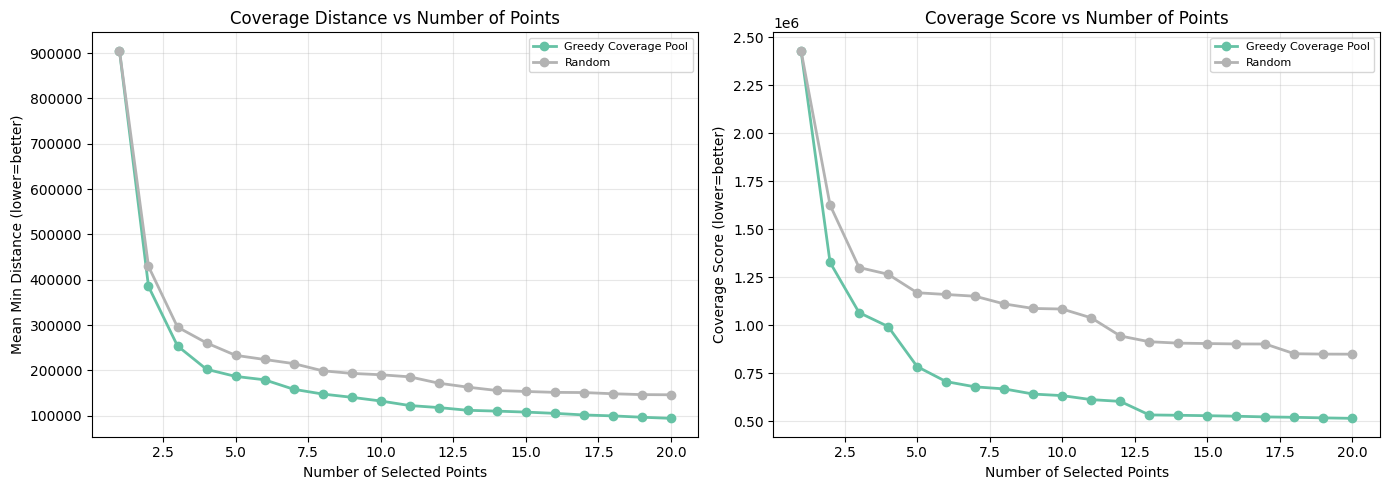

In [ ]:
# Coverage vs Number of Points (Incremental Comparison)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Group by Method and n_points, average across seeds
summary_by_npoints = (
    df_results.groupby(["Method", "n_points"])[["Mean Min Dist", "Coverage Score"]]
    .agg(["mean", "std"])
    .reset_index()
)

methods = df_results["Method"].unique()
colors = plt.cm.Set2(np.linspace(0, 1, len(methods)))

# Plot Mean Min Distance vs n_points
ax1 = axes[0]
for i, method in enumerate(methods):
    method_data = summary_by_npoints[summary_by_npoints["Method"] == method]
    n_pts = method_data["n_points"].values
    mean_vals = method_data[("Mean Min Dist", "mean")].values
    std_vals = method_data[("Mean Min Dist", "std")].values

    ax1.plot(n_pts, mean_vals, marker="o", label=method, color=colors[i], linewidth=2)
    # ax1.fill_between(
    #     n_pts, mean_vals - std_vals, mean_vals + std_vals, alpha=0.2, color=colors[i]
    # )

ax1.set_xlabel("Number of Selected Points")
ax1.set_ylabel("Mean Min Distance (lower=better)")
ax1.set_title("Coverage Distance vs Number of Points")
ax1.legend(loc="best", fontsize=8)
ax1.grid(True, alpha=0.3)

# Plot Coverage Score vs n_points
ax2 = axes[1]
for i, method in enumerate(methods):
    method_data = summary_by_npoints[summary_by_npoints["Method"] == method]
    n_pts = method_data["n_points"].values
    mean_vals = method_data[("Coverage Score", "mean")].values
    std_vals = method_data[("Coverage Score", "std")].values

    ax2.plot(n_pts, mean_vals, marker="o", label=method, color=colors[i], linewidth=2)
    # ax2.fill_between(
    #     n_pts, mean_vals - std_vals, mean_vals + std_vals, alpha=0.2, color=colors[i]
    # )

ax2.set_xlabel("Number of Selected Points")
ax2.set_ylabel("Coverage Score (lower=better)")
ax2.set_title("Coverage Score vs Number of Points")
ax2.legend(loc="best", fontsize=8)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

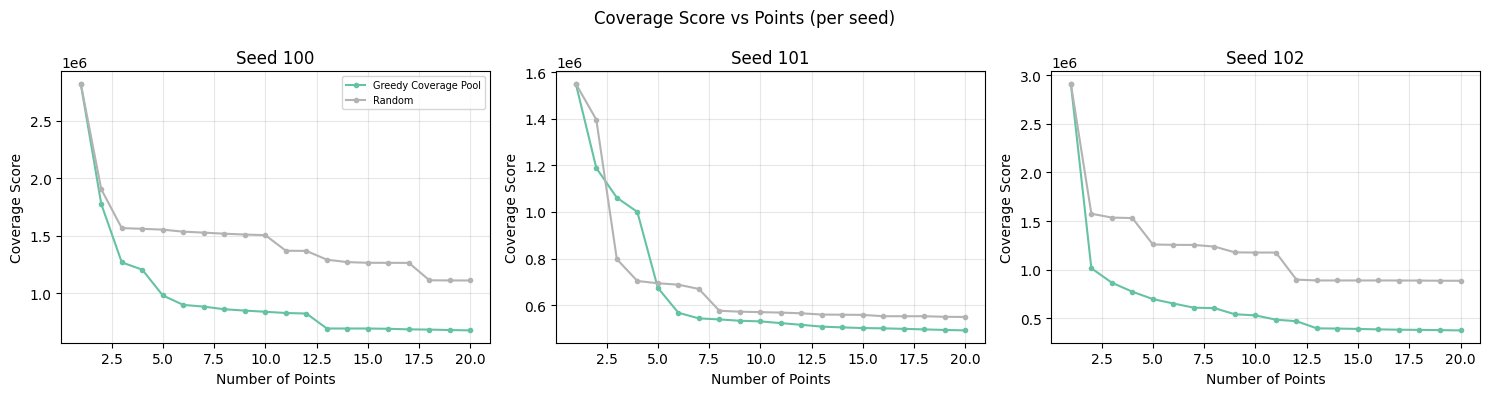

In [ ]:
# Per-seed Coverage Curves (to show variability)

fig, axes = plt.subplots(1, len(SEEDS), figsize=(5 * len(SEEDS), 4))

methods = df_results["Method"].unique()
colors = plt.cm.Set2(np.linspace(0, 1, len(methods)))

for idx, seed in enumerate(SEEDS):
    ax = axes[idx] if len(SEEDS) > 1 else axes
    df_seed = df_results[df_results["Seed"] == seed]

    for i, method in enumerate(methods):
        method_data = df_seed[df_seed["Method"] == method].sort_values("n_points")
        ax.plot(
            method_data["n_points"],
            method_data["Coverage Score"],
            marker="o",
            label=method,
            color=colors[i],
            linewidth=1.5,
            markersize=3,
        )

    ax.set_xlabel("Number of Points")
    ax.set_ylabel("Coverage Score")
    ax.set_title(f"Seed {seed}")
    ax.grid(True, alpha=0.3)
    if idx == 0:
        ax.legend(fontsize=7, loc="upper right")

plt.suptitle("Coverage Score vs Points (per seed)")
plt.tight_layout()
plt.show()

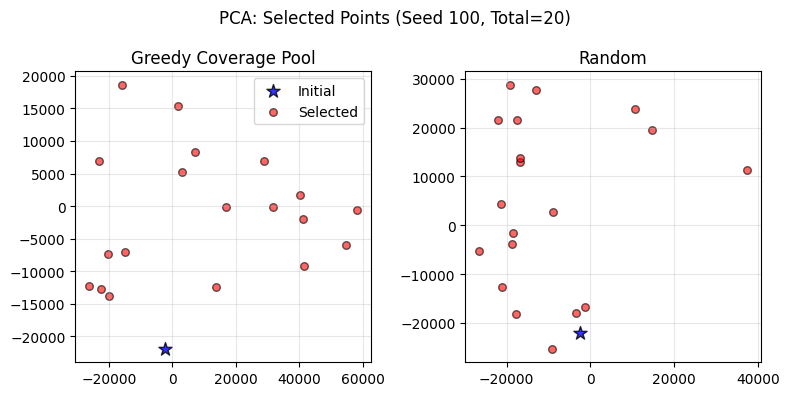

PCA explained variance: 70.40%, 26.88%


In [ ]:
# PCA Visualization of Selected Points (Final State)
from sklearn.decomposition import PCA

seed_to_show = SEEDS[0]
config_key = (seed_to_show, TOTAL_POINTS)
features_dict = all_features_by_config[config_key]

methods_to_plot = [
    k for k in features_dict.keys() if k not in ["Initial", "n_init_actual"]
]
n_methods = len(methods_to_plot)

# Combine all features for PCA
all_feats_list = [features_dict["Initial"]]
for m in methods_to_plot:
    all_feats_list.append(features_dict[m])
all_feats = np.vstack(all_feats_list)

pca = PCA(n_components=2)
pca.fit(all_feats)

fig, axes = plt.subplots(1, n_methods, figsize=(4 * n_methods, 4))

features_init = features_dict["Initial"]
features_init_pca = pca.transform(features_init)
n_init_actual = features_dict.get("n_init_actual", 1)

for j, method in enumerate(methods_to_plot):
    ax = axes[j] if n_methods > 1 else axes
    features_method = features_dict[method]
    features_method_pca = pca.transform(features_method)

    # Plot Initial point
    ax.scatter(
        features_init_pca[:, 0],
        features_init_pca[:, 1],
        c="blue",
        alpha=0.8,
        label="Initial",
        s=100,
        marker="*",
        edgecolors="k",
    )

    # Plot New points
    if len(features_method) > n_init_actual:
        features_new_pca = features_method_pca[n_init_actual:]
        ax.scatter(
            features_new_pca[:, 0],
            features_new_pca[:, 1],
            c="red",
            alpha=0.6,
            label="Selected",
            s=30,
            edgecolors="k",
        )

    ax.set_title(method)
    ax.grid(True, alpha=0.3)
    if j == 0:
        ax.legend()

plt.suptitle(f"PCA: Selected Points (Seed {seed_to_show}, Total={TOTAL_POINTS})")
plt.tight_layout()
plt.show()

print(
    f"PCA explained variance: {pca.explained_variance_ratio_[0]:.2%}, {pca.explained_variance_ratio_[1]:.2%}"
)

## Multi-Range Initial Conditions Comparison

Test multiple ranges of **intruder** initial conditions while keeping the **ownship fixed** (origin, facing north, fixed velocity). Compare Greedy Coverage Pool vs Random to identify which intruder parameter range yields better coverage.


In [15]:
# ============================================================
# Multi-Range Initial Conditions Comparison
# ============================================================
# Test different intruder parameter ranges and compare Greedy Coverage Pool vs Random.
# Ownship is FIXED: position at origin, facing north (θ=π/2), fixed velocity.
# Only intruder parameters vary: separation, intruder_v, placement_angle, intruder_theta.

# Fixed ownship parameters
FIXED_OWNSHIP_V = 800.0  # ft/s (fixed ownship velocity)
FIXED_OWNSHIP_THETA = np.pi / 2  # facing north

RANGE_CONFIGS = [
    {
        "name": "Default",
        "separation": (10000.0, 40000.0),
        "intruder_v": (0.0, 1200.0),
        "angle_constraint": (
            np.pi / 6,
            np.pi / 3,
        ),  # 30-60 deg off from direct collision course
    },
    {
        "name": "Close separation",
        "separation": (5000.0, 20000.0),
        "intruder_v": (0.0, 1200.0),
        "angle_constraint": (np.pi / 6, np.pi / 3),
    },
    {
        "name": "Far separation",
        "separation": (25000.0, 50000.0),
        "intruder_v": (0.0, 1200.0),
        "angle_constraint": (np.pi / 6, np.pi / 3),
    },
    {
        "name": "Slow intruder",
        "separation": (10000.0, 40000.0),
        "intruder_v": (0.0, 600.0),
        "angle_constraint": (np.pi / 6, np.pi / 3),
    },
    {
        "name": "Fast intruder",
        "separation": (10000.0, 40000.0),
        "intruder_v": (600.0, 1200.0),
        "angle_constraint": (np.pi / 6, np.pi / 3),
    },
    {
        "name": "Wide angle (30-90 deg)",
        "separation": (10000.0, 40000.0),
        "intruder_v": (0.0, 1200.0),
        "angle_constraint": (np.pi / 6, np.pi / 2),  # 30-90 deg
    },
    {
        "name": "Narrow angle (30-45 deg)",
        "separation": (10000.0, 40000.0),
        "intruder_v": (0.0, 1200.0),
        "angle_constraint": (np.pi / 6, np.pi / 4),  # 30-45 deg
    },
]


def sample_constrained_custom(n_samples, config, seed=None):
    """
    Sample initial conditions with fixed ownship and custom intruder bounds.

    Ownship is fixed: origin, facing north (θ=π/2), velocity=FIXED_OWNSHIP_V.
    Only intruder parameters (separation, intruder_v, placement_angle, intruder_theta) vary.
    Angle constraint: intruder faces toward ownship within ±angle_constraint range.
    """
    if seed is not None:
        np.random.seed(seed)

    sep_lo, sep_hi = config["separation"]
    iv_lo, iv_hi = config["intruder_v"]
    angle_lo, angle_hi = config["angle_constraint"]

    samples = []
    for _ in range(n_samples):
        separation = np.random.uniform(sep_lo, sep_hi)
        intruder_v = np.random.uniform(iv_lo, iv_hi)
        intruder_placement_angle = np.random.uniform(0, 2 * np.pi)

        # Direction from intruder toward ownship
        toward_ownship = (intruder_placement_angle + np.pi) % (2 * np.pi)

        # Intruder heading: faces toward ownship with angle offset within constraint
        angle_diff = np.random.uniform(angle_lo, angle_hi)
        direction = np.random.choice([-1, 1])
        intruder_theta = (toward_ownship + direction * angle_diff) % (2 * np.pi)

        sample = np.array(
            [
                separation,
                FIXED_OWNSHIP_V,  # fixed
                intruder_v,
                FIXED_OWNSHIP_THETA,  # fixed (north)
                intruder_placement_angle,
                intruder_theta,
            ]
        )
        samples.append(sample)

    return np.array(samples)


# Experiment parameters
RANGE_SEEDS = range(100, 105)
RANGE_TOTAL_POINTS = 15  # Points to select (including initial)
RANGE_N_VAL = 150  # Validation set size
RANGE_N_POOL = 300  # Pool size for greedy

range_all_results = []

print(
    f"Multi-Range Comparison: {len(RANGE_CONFIGS)} configs × {len(RANGE_SEEDS)} seeds"
)
print(
    f"Fixed ownship: pos=(0,0), θ={np.rad2deg(FIXED_OWNSHIP_THETA):.0f}° (north), v={FIXED_OWNSHIP_V:.0f} ft/s"
)
print(f"Points={RANGE_TOTAL_POINTS}, Val={RANGE_N_VAL}, Pool={RANGE_N_POOL}")
print()

for cfg_idx, config in enumerate(RANGE_CONFIGS):
    config_name = config["name"]
    print(f"\n{'='*70}")
    print(f"CONFIG {cfg_idx+1}/{len(RANGE_CONFIGS)}: {config_name}")
    print(f"  Separation:  {config['separation']}")
    print(f"  Intruder V:  {config['intruder_v']}")
    print(
        f"  Angle diff:  {np.rad2deg(config['angle_constraint'][0]):.0f}-{np.rad2deg(config['angle_constraint'][1]):.0f} deg off from toward-ownship direction"
    )
    print(f"{'='*70}")

    for seed in RANGE_SEEDS:
        np.random.seed(seed)
        print(f"\n  Seed {seed}:")

        # Generate initial point
        init_point = sample_constrained_custom(1, config, seed=seed * 7)

        # Generate validation set
        val_initial_conds = sample_constrained_custom(
            RANGE_N_VAL, config, seed=seed * 13
        )

        # Generate pool (for greedy)
        pool_initial_conds = sample_constrained_custom(
            RANGE_N_POOL, config, seed=seed * 17
        )

        # ---- Pre-compute trajectories for Greedy Coverage Pool ----
        print(f"    Pre-computing trajectories...", end=" ")
        start_time = time.time()

        combined_conds = np.vstack([init_point, pool_initial_conds])
        n_combined = len(combined_conds)

        pool_cases = initial_conditions_to_testcases(
            combined_conds, intruder_can_turn=True, seed=seed * 100
        )
        pool_results = evaluate_acasxu_dubins_cases(pool_cases)
        pool_trajectories = [
            extract_acasxu_dubins_trajectory(r, aircraft_index=-1)
            for r in pool_results
            if not r.simulation_failed
        ]

        val_cases = initial_conditions_to_testcases(
            val_initial_conds, intruder_can_turn=True, seed=seed * 100
        )
        val_results_list = evaluate_acasxu_dubins_cases(val_cases)
        val_trajectories = [
            extract_acasxu_dubins_trajectory(r, aircraft_index=-1)
            for r in val_results_list
            if not r.simulation_failed
        ]

        all_trajectories_combined = pool_trajectories + val_trajectories
        n_pool = len(pool_trajectories)
        n_val = len(val_trajectories)

        if n_pool < 2 or n_val < 2:
            print(f"SKIP (pool={n_pool}, val={n_val})")
            continue

        full_dist_matrix = pairwise_dubins_distances(
            all_trajectories_combined, distance_type="dtw"
        )
        pool_to_val_dist = full_dist_matrix[:n_pool, n_pool:]  # (n_pool, n_val)

        pool_time = time.time() - start_time
        print(f"done ({pool_time:.1f}s, pool={n_pool}, val={n_val})")

        # ---- Greedy Coverage Pool: incremental selection ----
        greedy_selected_indices = [0]
        greedy_history = []

        # Initial coverage
        init_selected_dists = pool_to_val_dist[[0], :]  # (1, n_val)
        init_val_min_dists = np.min(init_selected_dists, axis=0)
        init_score = np.mean(init_val_min_dists) + 0.5 * np.max(init_val_min_dists)
        greedy_history.append({"n_points": 1, "coverage_score": init_score})

        n_cycles = RANGE_TOTAL_POINTS - 1
        for cycle in range(n_cycles):
            selected_set = set(greedy_selected_indices)
            remaining = [i for i in range(1, n_combined) if i not in selected_set]

            if not remaining:
                break

            current_val_min_dists = np.min(
                pool_to_val_dist[list(selected_set), :], axis=0
            )

            best_idx = None
            best_score = np.inf
            for idx in remaining:
                candidate_dists = pool_to_val_dist[idx, :]
                new_val_min_dists = np.minimum(current_val_min_dists, candidate_dists)
                score = np.mean(new_val_min_dists) + 0.5 * np.max(new_val_min_dists)
                if score < best_score:
                    best_score = score
                    best_idx = idx

            greedy_selected_indices.append(best_idx)
            greedy_history.append(
                {
                    "n_points": cycle + 2,
                    "coverage_score": best_score,
                }
            )

        # ---- Random: incremental selection ----
        random_history = []
        random_selected_conds = init_point.copy()

        # Initial coverage (same point, so same score)
        random_history.append({"n_points": 1, "coverage_score": init_score})

        for cycle in range(n_cycles):
            # Sample random point with same fixed-ownship config
            random_new = sample_constrained_custom(1, config, seed=seed * 10000 + cycle)
            random_selected_conds = np.vstack([random_selected_conds, random_new])

            # Evaluate actual coverage for random
            random_cov = evaluate_coverage_actual(
                random_selected_conds,
                val_initial_conds,
                intruder_cmd_seed=seed * 100,
                verbose=False,
            )
            random_history.append(
                {
                    "n_points": cycle + 2,
                    "coverage_score": random_cov["coverage_score"],
                }
            )

        # ---- Store results ----
        for entry in greedy_history:
            range_all_results.append(
                {
                    "Config": config_name,
                    "Seed": seed,
                    "n_points": entry["n_points"],
                    "Method": "Greedy Coverage Pool",
                    "Coverage Score": entry["coverage_score"],
                }
            )
        for entry in random_history:
            range_all_results.append(
                {
                    "Config": config_name,
                    "Seed": seed,
                    "n_points": entry["n_points"],
                    "Method": "Random",
                    "Coverage Score": entry["coverage_score"],
                }
            )

        # Print final scores
        greedy_final = greedy_history[-1]["coverage_score"]
        random_final = random_history[-1]["coverage_score"]
        improvement = (random_final - greedy_final) / random_final * 100

        print(
            f"    Final scores: Greedy={greedy_final:.2f}, Random={random_final:.2f} ({improvement:+.1f}% improvement)"
        )

Multi-Range Comparison: 7 configs × 5 seeds
Fixed ownship: pos=(0,0), θ=90° (north), v=800 ft/s
Points=15, Val=150, Pool=300


CONFIG 1/7: Default
  Separation:  (10000.0, 40000.0)
  Intruder V:  (0.0, 1200.0)
  Angle diff:  30-60 deg off from toward-ownship direction

  Seed 100:
    Pre-computing trajectories... done (58.8s, pool=301, val=150)
    Final scores: Greedy=536962.57, Random=844042.84 (+36.4% improvement)

  Seed 101:
    Pre-computing trajectories... done (59.8s, pool=301, val=150)
    Final scores: Greedy=409588.01, Random=867606.31 (+52.8% improvement)

  Seed 102:
    Pre-computing trajectories... done (58.3s, pool=301, val=150)
    Final scores: Greedy=1723164.00, Random=2788681.21 (+38.2% improvement)

  Seed 103:
    Pre-computing trajectories... done (62.7s, pool=301, val=150)
    Final scores: Greedy=809169.38, Random=709322.29 (-14.1% improvement)

  Seed 104:
    Pre-computing trajectories... done (55.0s, pool=301, val=150)
    Final scores: Greedy=238159.48, Ra

Final Coverage Scores by Range Config (mean ± std over seeds)
  Default                   | Greedy:  743408.69 ± 585998.71 | Random: 1133351.50 ± 939620.50 | Δ: +34.4%
  Close separation          | Greedy:  223104.00 ± 169235.05 | Random:  363279.71 ± 339334.08 | Δ: +38.6%
  Far separation            | Greedy: 1131535.52 ± 388188.00 | Random: 1973033.20 ± 811304.41 | Δ: +42.6%
  Slow intruder             | Greedy:  227275.82 ± 34297.03 | Random:  552089.32 ± 155751.22 | Δ: +58.8%
  Fast intruder             | Greedy:  621686.24 ± 203679.77 | Random: 1540203.51 ± 958126.84 | Δ: +59.6%
  Wide angle (30-90 deg)    | Greedy:  470954.32 ± 159311.35 | Random:  994860.88 ± 350687.75 | Δ: +52.7%
  Narrow angle (30-45 deg)  | Greedy:  459659.55 ± 178947.40 | Random: 1380775.47 ± 482265.94 | Δ: +66.7%


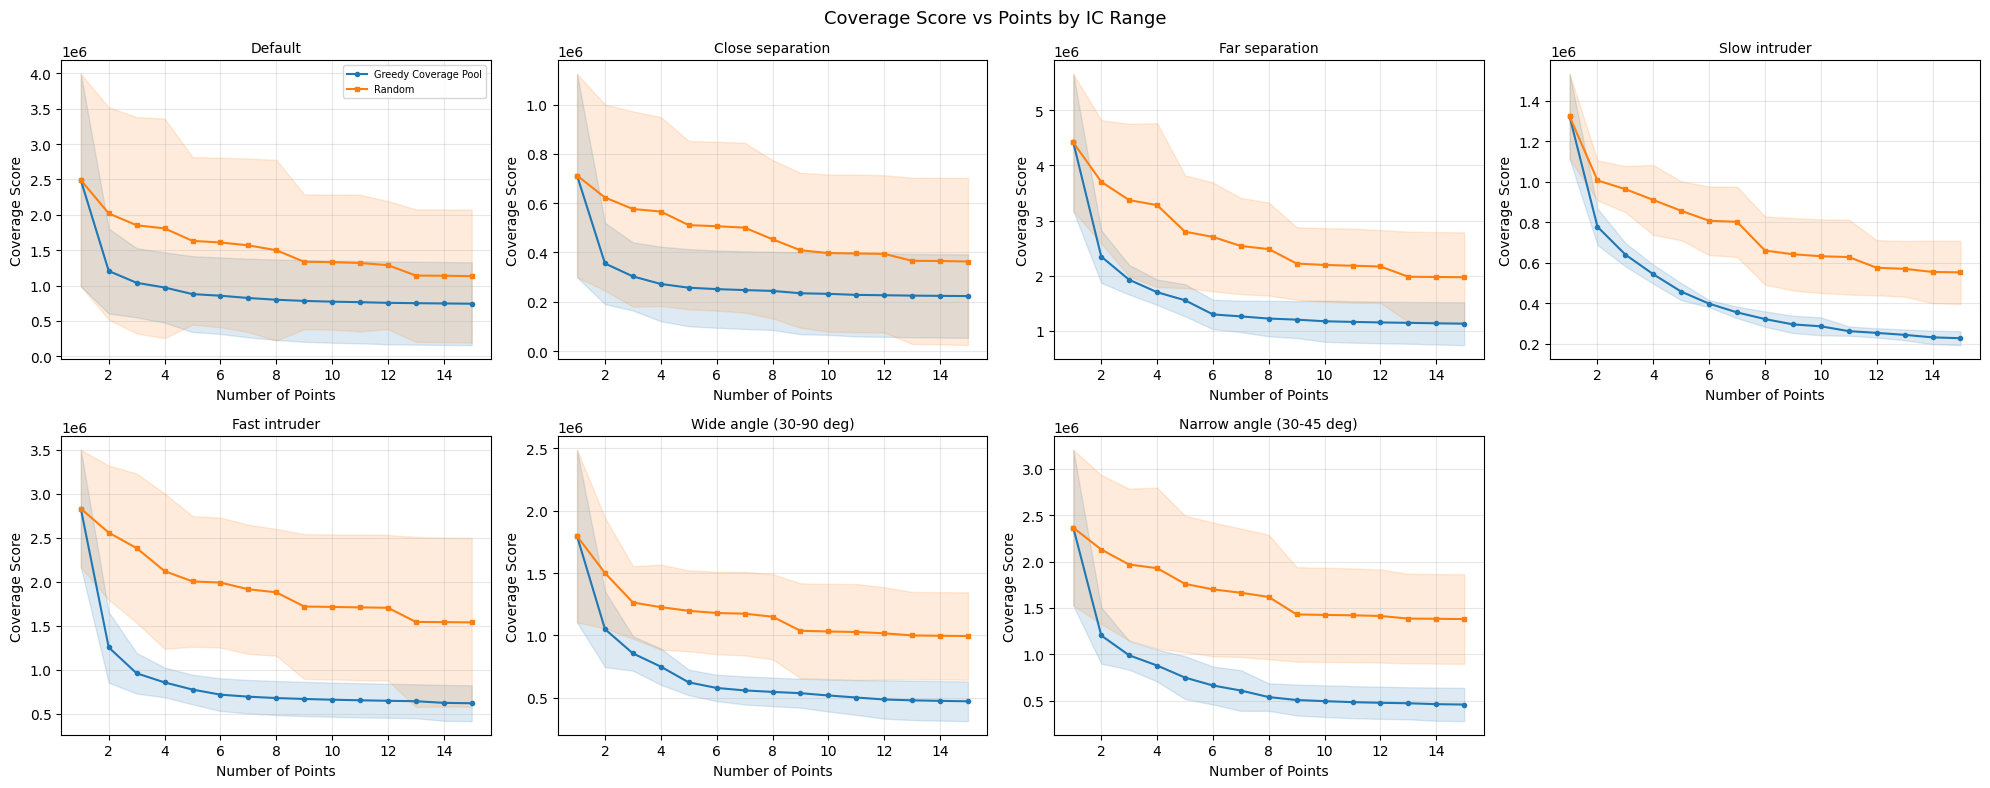

/var/folders/xc/5zwwryv54b9cssx5nwq1wfr00000gn/T/ipykernel_90972/4050764912.py:138: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(config_names, rotation=30, ha="right", fontsize=9)


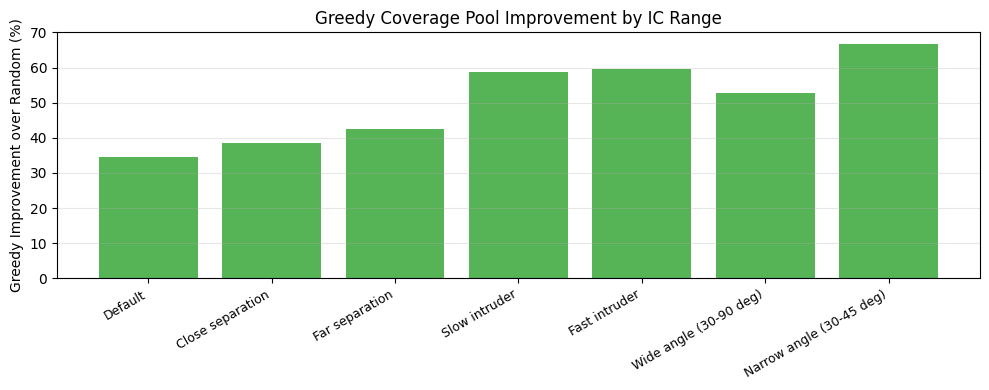


Statistical Tests (Mann-Whitney U) per Config at final point count:
----------------------------------------------------------------------
  Default                  : p=0.1548 (n.s.)
  Close separation         : p=0.1548 (n.s.)
  Far separation           : p=0.1111 (n.s.)
  Slow intruder            : p=0.0040 *
  Fast intruder            : p=0.0278 *
  Wide angle (30-90 deg)   : p=0.0079 *
  Narrow angle (30-45 deg) : p=0.0159 *


In [16]:
# ============================================================
# Multi-Range Results Analysis & Visualization
# ============================================================

import pandas as pd

df_range = pd.DataFrame(range_all_results)

# --- 1. Summary table: Final coverage score by config × method ---
df_final_range = df_range[df_range["n_points"] == RANGE_TOTAL_POINTS]
summary_table = df_final_range.pivot_table(
    index="Config", columns="Method", values="Coverage Score", aggfunc=["mean", "std"]
)
print("=" * 70)
print("Final Coverage Scores by Range Config (mean ± std over seeds)")
print("=" * 70)
for config_name in [c["name"] for c in RANGE_CONFIGS]:
    greedy_mean = summary_table[("mean", "Greedy Coverage Pool")].get(
        config_name, np.nan
    )
    greedy_std = summary_table[("std", "Greedy Coverage Pool")].get(config_name, np.nan)
    random_mean = summary_table[("mean", "Random")].get(config_name, np.nan)
    random_std = summary_table[("std", "Random")].get(config_name, np.nan)
    improvement = (
        (random_mean - greedy_mean) / random_mean * 100 if random_mean > 0 else 0
    )
    print(
        f"  {config_name:<25s} | Greedy: {greedy_mean:>10.2f} ± {greedy_std:>7.2f} | Random: {random_mean:>10.2f} ± {random_std:>7.2f} | Δ: {improvement:+.1f}%"
    )

# --- 2. Coverage curves: one subplot per config ---
configs_list = [c["name"] for c in RANGE_CONFIGS]
n_configs = len(configs_list)
ncols = min(4, n_configs)
nrows = (n_configs + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), squeeze=False)

for idx, config_name in enumerate(configs_list):
    row, col = divmod(idx, ncols)
    ax = axes[row][col]
    df_cfg = df_range[df_range["Config"] == config_name]

    # Average across seeds
    summary_by_np = (
        df_cfg.groupby(["Method", "n_points"])["Coverage Score"]
        .agg(["mean", "std"])
        .reset_index()
    )

    for method, color, marker in [
        ("Greedy Coverage Pool", "tab:blue", "o"),
        ("Random", "tab:orange", "s"),
    ]:
        method_data = summary_by_np[summary_by_np["Method"] == method]
        n_pts = method_data["n_points"].values
        mean_vals = method_data["mean"].values
        std_vals = method_data["std"].values

        ax.plot(
            n_pts,
            mean_vals,
            marker=marker,
            label=method,
            color=color,
            linewidth=1.5,
            markersize=3,
        )
        ax.fill_between(
            n_pts, mean_vals - std_vals, mean_vals + std_vals, alpha=0.15, color=color
        )

    ax.set_xlabel("Number of Points")
    ax.set_ylabel("Coverage Score")
    ax.set_title(config_name, fontsize=10)
    ax.grid(True, alpha=0.3)
    if idx == 0:
        ax.legend(fontsize=7)

# Hide unused subplots
for idx in range(n_configs, nrows * ncols):
    row, col = divmod(idx, ncols)
    axes[row][col].set_visible(False)

plt.suptitle("Coverage Score vs Points by IC Range", fontsize=13)
plt.tight_layout()
plt.show()

# --- 3. Bar chart: final Greedy improvement over Random per config ---
# fig, ax = plt.subplots(figsize=(10, 5))

config_names = []
improvements = []
greedy_means = []
random_means = []

for config_name in configs_list:
    df_cfg_final = df_final_range[df_final_range["Config"] == config_name]
    g_mean = df_cfg_final[df_cfg_final["Method"] == "Greedy Coverage Pool"][
        "Coverage Score"
    ].mean()
    r_mean = df_cfg_final[df_cfg_final["Method"] == "Random"]["Coverage Score"].mean()
    config_names.append(config_name)
    greedy_means.append(g_mean)
    random_means.append(r_mean)
    improvements.append((r_mean - g_mean) / r_mean * 100 if r_mean > 0 else 0)

# x = np.arange(len(config_names))
# width = 0.35

# bars1 = ax.bar(
#     x - width / 2,
#     greedy_means,
#     width,
#     label="Greedy Coverage Pool",
#     color="tab:blue",
#     alpha=0.8,
# )
# bars2 = ax.bar(
#     x + width / 2, random_means, width, label="Random", color="tab:orange", alpha=0.8
# )

# ax.set_ylabel("Final Coverage Score (lower = better)")
# ax.set_title("Final Coverage Score by IC Range")
# ax.set_xticks(x)
# ax.set_xticklabels(config_names, rotation=30, ha="right", fontsize=9)
# ax.legend()
# ax.grid(True, alpha=0.3, axis="y")
# plt.tight_layout()
# plt.show()

# --- 4. Improvement bar chart ---
fig, ax = plt.subplots(figsize=(10, 4))
colors = ["tab:green" if imp > 0 else "tab:red" for imp in improvements]
ax.bar(config_names, improvements, color=colors, alpha=0.8)
ax.set_ylabel("Greedy Improvement over Random (%)")
ax.set_title("Greedy Coverage Pool Improvement by IC Range")
ax.set_xticklabels(config_names, rotation=30, ha="right", fontsize=9)
ax.axhline(y=0, color="black", linewidth=0.5)
ax.grid(True, alpha=0.3, axis="y")
plt.tight_layout()
plt.show()

# --- 5. Statistical tests per config ---
print("\nStatistical Tests (Mann-Whitney U) per Config at final point count:")
print("-" * 70)
for config_name in configs_list:
    df_cfg_final = df_final_range[df_final_range["Config"] == config_name]
    greedy_scores = df_cfg_final[df_cfg_final["Method"] == "Greedy Coverage Pool"][
        "Coverage Score"
    ].values
    random_scores = df_cfg_final[df_cfg_final["Method"] == "Random"][
        "Coverage Score"
    ].values
    if len(greedy_scores) >= 2 and len(random_scores) >= 2:
        _, p_val = stats.mannwhitneyu(greedy_scores, random_scores, alternative="less")
        print(
            f"  {config_name:<25s}: p={p_val:.4f} {'*' if p_val < 0.05 else '(n.s.)'}"
        )
    else:
        print(f"  {config_name:<25s}: insufficient samples")